# Code to make Figure 15
- Decadal map composites over southern Ross Sea for ocean variables
- Notebook by Alice DuVivier (NCAR)
- February 2023

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import dask
import utils
import cmocean
import geopandas as gpd

In [2]:
# set the location of the already extracted training data
sector_short = 'Ross'
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/'+sector_short+'_analysis_v4/'
path_out = path_in+'figures_outline/'
# set shape files info
fname= '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp' 

### Specify variables to plot

In [3]:
# set path to the pulled data
# Note data is for larger area than only training points
# this data has been processed all the same 'time' coordinates as training data
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'

# set what variables we can plot
vars_composite_in = ['fhocn_avg', 'HMXL_sept', 'NPP_total' ]

In [49]:
# USER CHOOSE WHICH VARIABLE TO PLOT: 0-1
n = 2
var_in = vars_composite_in[n] 

In [50]:
# file name for training variable only here 
fin = 'antarctic_data_for_som_composites_'+var_in

In [51]:
# load data
ds = xr.open_mfdataset(data_path_in+fin+'.nc')

In [52]:
# keep just the region of interest
data = ds.data.where((ds.TLONG > 140.0) & (ds.TLONG < 230.0) & (ds.TLAT < -68.0))

In [53]:
# convert from cm to meters
if var_in == 'HMXL_sept':
    data = data/100.
    ds['units'] = 'meters'
# convert to 1000's of mmol/m2
if var_in == 'NPP_total':
    data = data/1000.

In [54]:
data.time

<xarray.DataArray 'time' (training_times: 2525)>
dask.array<open_dataset-565fbd587096ddc40596b403cda6ae9etime, shape=(2525,), dtype=int64, chunksize=(2525,), chunktype=numpy.ndarray>
Coordinates:
    time       (training_times) int64 dask.array<chunksize=(2525,), meta=np.ndarray>
    member_id  (training_times) object dask.array<chunksize=(2525,), meta=np.ndarray>
Dimensions without coordinates: training_times

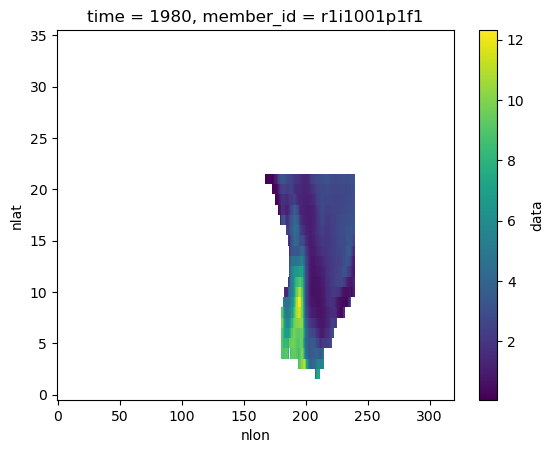

In [55]:
data.isel(training_times=0).plot()

In [56]:
# explicitly load data so that it doesn't take forever later on during mean
data = data.load()

## Calculate the mean for all winter by decade

In [57]:
# calculate winter mean against which to do anomalies
data_mean = data.mean(dim='training_times')

In [58]:
decades = list(range(1980,2080,10))
decade_names = ['1980','1990', '2000', '2010', '2020', '2030', '2040', '2050', '2060', '2070']

In [59]:
# make numpy array to fill and specify dimensions we want
decade_array = np.zeros([len(decade_names),len(data_mean.nlat),len(data_mean.nlon)])

for dd in decade_names:
    print('decade: '+dd+'s')
    if dd == '1980':
        d_count = 0
        yy_st = 1980
    else: 
        d_count = d_count+1
        yy_st = yy_st + 10
    # get years for this decade
    yy_ed = yy_st + 10
    yy_all = list(range(yy_st,yy_ed,1))
    # get mean for this decade
    if var_in == 'HMXL_sept':
        decade_array[d_count,:,:]   = data.isel(training_times=data.time.dt.year.isin([yy_all])).mean(dim='training_times')
    if var_in == 'NPP_total':
        decade_array[d_count,:,:] = data.isel(training_times=data.time.isin([yy_all])).mean(dim='training_times')
    if var_in == 'fhocn_avg':
        decade_array[d_count,:,:] = data.isel(training_times=data.time.isin([yy_all])).mean(dim='training_times') 
        
    

decade: 1980s
decade: 1990s
decade: 2000s
decade: 2010s
decade: 2020s
decade: 2030s
decade: 2040s
decade: 2050s
decade: 2060s
decade: 2070s


In [60]:
print(decade_array.shape)

(10, 36, 320)


In [61]:
# convert the numpy array to a xarray for easier plotting
decade_means = xr.DataArray(decade_array,dims=('decade','nlat','nlon'))

In [62]:
# set coordinate arrays
decade_means['decade'] = decade_names
decade_means['nlat'] = data_mean['nlat'].values
decade_means['nlon'] = data_mean['nlon'].values

## Plot the decadal winter means and differences

In [63]:
# Set plotting limits
lat_max = -72
lat_min = -80
lon_max = 200
lon_min = 160
lon_avg = 190

In [64]:
#set shape files info
shdf = gpd.read_file(fname)
# This line is important. Here we convert the projection from the shapefile one to the cartopy one 
shdf = shdf.to_crs(ccrs.SouthPolarStereo())

# Shapefile projection conversion
shdf = gpd.read_file(fname)
shdf = shdf.to_crs(ccrs.SouthPolarStereo(central_longitude=lon_avg))

In [65]:
# bootstrap significance calculation 
# (only should be done for the far right panel; the diffs)

num_iterations = 10000  # this number should be somewhere between 1,000 to 10,000

# create empty array to use for percentile calculation
boot_diff_array = np.zeros((num_iterations, 
                      decade_means.isel(decade=0).shape[0],
                      decade_means.isel(decade=0).shape[1]))

# loop to bootstrap sample array of decades
for i in range(num_iterations):

    ar1 = np.random.choice(np.arange(0,10,1)) # pick random int
    ar2 = np.random.choice(np.arange(0,10,1)) # pick random int
    
    arr1 = 100 * decade_means.isel(decade=ar1) # pick random decade
    arr2 = 100 * decade_means.isel(decade=ar2) # pick random decade
    
    boot_diff_array[i,:,:] = arr1.values - arr2.values  # take diff of random decades

In [66]:
decade_means

<xarray.DataArray (decade: 10, nlat: 36, nlon: 320)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * decade   (decade) <U4 '1980' '1990' '2000' '2010' ... '2050' '2060' '2070'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

In [67]:
# convert the numpy array to a xarray for calculating
boot_diff = xr.DataArray(boot_diff_array,dims=('nboot','nlat','nlon'))

# set coordinate arrays
boot_diff['nlat'] = decade_means['nlat'].values
boot_diff['nlon'] = decade_means['nlon'].values

In [68]:
# using thresholds, we ask: "did this difference (2070-1980) occur by chance? or is it significant?"
# if it exceeds upper and lower bounds, it is likely that this did not occur by chance

# calculate unique value at all points over all bootstraps
max_thresh_all = boot_diff.quantile(0.975,dim='nboot')
min_thresh_all = boot_diff.quantile(0.025,dim='nboot')

/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [69]:
# set some labeling things

if var_in == 'fhocn_avg':
    units = '(W/m$^{2}$)'
    title_in = 'Winter ice-ocean heat flux\n'
    levels_in = np.arange(-100,110,10)
    ticks_in = [-100,-50,0,50,100]
    cmap_in = cmocean.cm.curl
    levels_diff = np.arange(-50,60,10)
    ticks_diff = [-50,-40,-30,-20,-10,0,10,20,30,40,50]
    levels_pct_diff = np.arange(-100,110,10)
    ticks_pct_diff = [-100,-50,0,50,100]
    cmap_diff = cmocean.cm.diff
    ext = 'both'
    # prefixes
    pref_1 = 'a) '
    pref_2 = 'b) '
    pref_3 = 'c) ' 
    pref_4 = 'd) '

if var_in == 'HMXL_sept':
    units = '(m)'
    title_in = 'Mixed Layer Depth\n'
    levels_in = np.arange(0,300,25)
    ticks_in = [0,50,100,150,200,250,300]
    cmap_in = cmocean.cm.deep
    levels_diff = np.arange(-100,120,20)
    ticks_diff = [-80,-40,0,40,80]
    levels_pct_diff = np.arange(-50,60,10)
    ticks_pct_diff = [-50,-40,-30,-20,-10,0,10,20,30,40,50]
    cmap_diff = cmocean.cm.diff
    ext = 'max'
    # prefixes
    pref_1 = 'e) '
    pref_2 = 'f) '
    pref_3 = 'g) '
    pref_4 = 'h) '
    
if var_in == 'NPP_total':
    units = '(10$^{3}$ mmol m$^{-2}$)'
    title_in = 'Net Marine Primary Production\n'
    levels_in = np.arange(0,16,1)
    ticks_in = [0,3,6,9,12,15]
    cmap_in = cmocean.cm.algae
    levels_diff = np.arange(-2,2.2,0.2)
    ticks_diff = [-2,-1,0,1,2]
    levels_pct_diff = np.arange(-50,55,5)
    ticks_pct_diff = [-50,-40,-30,-20,-10,0,10,20,30,40,50]
    cmap_diff = cmocean.cm.diff
    ext = 'max'
    # prefixes
    pref_1 = 'i) '
    pref_2 = 'j) '
    pref_3 = 'k) ' 
    pref_4 = 'l) '


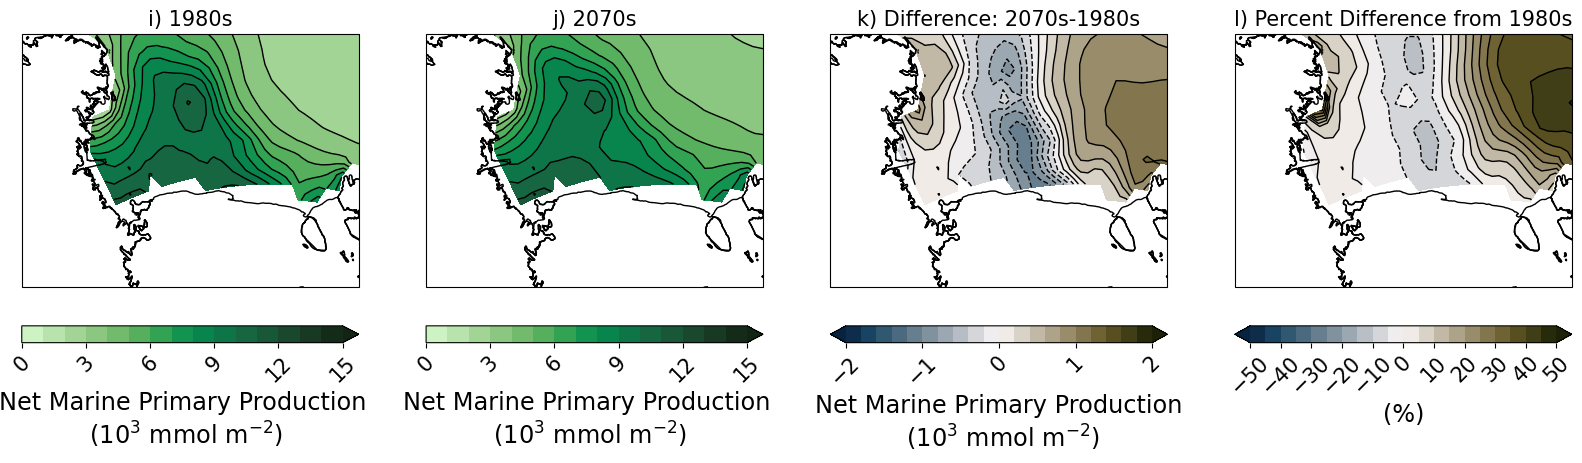

In [70]:
## 2070's difference figure
tag = '2070'

# select data
data_ctrl = decade_means.sel(decade='1980')
data_in = decade_means.sel(decade=tag)
data_diff = data_in - data_ctrl
data_pct_diff = 100*((data_in-data_ctrl)/abs(data_ctrl))

# keep only data that is significantly different
sig = data_diff.where((data_diff >= max_thresh_all)|(data_diff <= min_thresh_all))
# keep only data that is NOT significancly different because we want to stipple NOT significant points
sig2 = data_diff.where((data_diff <= max_thresh_all)&(data_diff >= min_thresh_all))

# create figure
fig = plt.figure(figsize=(20,10))
fout = path_out+'fig15_decadal_'+var_in

# get lats/lons for plotting
lons = ds.TLONG
lats = ds.TLAT

# plot the subplots - note it's nrow x ncol x index (starting upper left)
### mean over 1980s
ax = fig.add_subplot(1,4,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend=ext)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15,rotation=45)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_ctrl,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_1+'1980s',fontsize=15)

### mean future
ax = fig.add_subplot(1,4,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in, extend=ext)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15,rotation=45)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_in,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_in,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_2+tag+'s',fontsize=15)

### diff
ax = fig.add_subplot(1,4,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                     data_diff,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15,rotation=45)
cbar.set_label(title_in+' '+units, fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_diff,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_diff,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_diff)
# add significance overtop - stippling where it is NOT significant
#lon, lat, field = utils.adjust_pop_grid(lons, lats, sig2)
#this3 = ax.pcolor(lon,lat,
#                  field,
#                  transform=ccrs.PlateCarree(),
#                  hatch='.',
#                  alpha= 0)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_3+'Difference: '+tag+'s-1980s',fontsize=15)

### percent diff
ax = fig.add_subplot(1,4,4, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
this = ax.contourf(lons,lats,
                     data_pct_diff,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_pct_diff, extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_pct_diff,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15,rotation=45)
cbar.set_label('(%)', fontsize='xx-large')
# overlay contours
this2 = ax.contour(lons,lats,
                   data_pct_diff,
                   transform=ccrs.PlateCarree(),
                   colors = 'black', levels = levels_pct_diff,linewidths=1)
plt.clabel(this2,colors = 'black', inline=1,fontsize=10,levels=levels_pct_diff)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='none')
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(pref_4+'Percent Difference from 1980s',fontsize=15)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)